#Imports 


In [257]:
import copy
import json
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.tree as tree
from sklearn.tree import DecisionTreeClassifier


#Helper Functions

#Decision Tree Classifier

In [143]:
class DecisionTree:

    def __init__(self):
        self.tree = {}
        self.train_accuracy = 0
        self.train_loss = 0

    def train(self, features, labels, max_depth, min_samples):
        labels_reshaped = labels.reshape(labels.shape[0], -1)
        train_features = np.append(features, labels_reshaped, 1)

        self.tree = self.grow_tree(data=train_features, min_samples=min_samples, max_depth=max_depth)

        # accuracy, loss = self.evaluate(features, labels)
        # self.train_accuracy = accuracy
        # self.train_loss = loss
        self.print_tree()
        # print("train_accuracy: ", accuracy)
        # print("train_loss: ", loss)

        #return accuracy, loss

    def evaluate(self, features, labels):
        prediction = self.predict(features)
        # calculate accuracy
        accuracy = 0
        for predicted, actual in zip(prediction, labels):
            if predicted == actual:
                accuracy += 1

        accuracy = accuracy / len(labels)
        loss = 1 - accuracy
        # print("test_accuracy: ", accuracy)
        # print("test_ loss: ",loss)

        return accuracy,loss

    def predict(self, data):
        prediction = []
        for val in data:
            tree_copy = self.tree
            while type(tree_copy) != str:
                root = list(tree_copy.keys())
                root_str = root[0]
                # print(root, type(root))
                column_index, values = self.parse_key(root_str)
                for index, value in enumerate(values):
                    if value == val[column_index]:
                        # print(index, value, column_index, val[column_index])
                        children = tree_copy[root_str]
                        # print(children, type(children))
                        tree_copy = children[index]
                        # print(tree_copy, type(tree_copy))
                        break

            prediction.append(tree_copy)

        return prediction

    def classify_data(self, data):
        label_column = data[:, -1]
        unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

        index = counts_unique_classes.argmax()
        classification = unique_classes[index]

        return classification

    def grow_tree(self, data, counter=0, min_samples=3, max_depth=4):
        if self.check_purity(data) or (len(data) < min_samples) or counter == max_depth:
            label = self.classify_data(data)
            return label
        else:
            counter += 1

        best_feature_index = self.best_feature(data)
        values = np.unique(data[:, best_feature_index])
        continuous = False
        if type(values[0]) == int or type(values[0]) == float:
          continuous = True
          values = self.get_numeric_splits(values)[0]
        split_data = []
        for value in values:
            split_data.append(self.split(data, best_feature_index, value, continuous=continuous))

        node = "{}->{}".format(best_feature_index, str(values))
        sub_tree = {node: []}

        for elem in split_data:
            result = self.grow_tree(data=elem, counter=counter, min_samples=min_samples, max_depth=max_depth)
            sub_tree[node].append(result)

        # print(sub_tree)

        return sub_tree

    def best_feature(self, data):
        size = data.shape[1]
        # print(size)
        gains = []
        for i in range(size - 1):
            gains.append(self.information_gain(data, i))

        # print("Max index ", np.argmax(gains))

        return np.argmax(gains)

    def check_purity(self, data):
        unique_classes = np.unique(data[:, -1])

        if len(unique_classes) == 1:
            return True
        else:
            return False

    def entropy(self, data):
        labels = data[:, -1]
        unique_values = np.unique(labels, return_counts=True)
        # print(unique_values[1], len(data))
        prob = unique_values[1] / len(data)
        gain = np.sum(prob * -np.log2(prob))
        # print(gain)
        return gain

    def information_gain(self, data, split_index):
        previous_entropy = self.entropy(data)
        split_column = data[:, split_index]
        unique_values, unique_counts = np.unique(split_column, return_counts=True)
        # print(unique_values)
        # print(unique_counts, len(data))
        
        entropies = []

        continuous = False
        if type(unique_values[0]) == int or type(unique_values[0]) == float:
          print("continous \n")
          continuous = True
          unique_values, unique_counts = self.get_numeric_splits(unique_values)
        for value in unique_values:
            split_data = self.split(data, split_index, value, continuous=continuous)
            split_entropy = self.entropy(split_data)
            entropies.append(split_entropy)


        prob = unique_counts / len(data)

        new_entropy = previous_entropy - np.sum(prob * entropies)

        # print(new_entropy)
        return new_entropy

    def split(self, data, split_index, split_value, continuous = False):
        split_column = data[:, split_index]
        if split_value == '?' or split_value is None or split_value == '':
            unique_values, unique_indexes = np.unique(split_column, return_counts=True)
            split_value = unique_values[np.argmax(unique_indexes)]

        if continuous:
          new_data = data[split_column <= split_value]
        else:
          new_data = data[split_column == split_value]
        return new_data

    def parse_key(self, key_str):
        column_index, values = key_str.split('->')
        column_index = int(column_index)
        values = values.replace("[", "").replace("]", "") \
            .replace("'", "").replace("'", "").split(" ")

        return column_index, values

    def get_numeric_splits(self, value):
        distance_values = []
        for index in range(len(value)):
          if index != 0:
            current_value = value[index]
            previous_value = value[index - 1]
            distance_values.append((current_value + previous_value) / 2)

        unique_values, unique_counts = np.unique(distance_values, return_counts=True)

        return unique_values, unique_counts

    def print_tree(self):
        print(json.dumps(self.tree, indent=4, default=str))


#Data

In [267]:
df = pd.read_excel('/content/ISU Case Competition - Test File (1).xlsx')

In [268]:
cols = df.select_dtypes(['object']).columns
df[cols] = df[cols].apply(lambda x: x.str.strip())

In [269]:
cols = [col for col in df.columns if col not in ['First Name','Last Name ', 'Application Number','Application Date','Loan Approved']]

In [270]:
label_df = df['Loan Approved']
#, labels=['fisrtq', 'secondq', 'thirdq', 'fourthq']

In [271]:
df = df[cols]

In [277]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11678 entries, 0 to 11677
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Gender       11678 non-null  object  
 1   Nationality  11678 non-null  object  
 2   Ethnicity    11678 non-null  object  
 3   Employment   11678 non-null  object  
 4   City         11678 non-null  object  
 5   State        11678 non-null  object  
 6   AgeC         11678 non-null  category
 7   FICOC        11678 non-null  category
 8   AmountC      11678 non-null  category
 9   RateC        11678 non-null  category
 10  Loan Months  11678 non-null  category
 11  PaymentC     11678 non-null  category
dtypes: category(6), object(6)
memory usage: 617.2+ KB


In [273]:
df['AgeC'] = pd.qcut(df['Age'], q=4,labels=['age1q', 'age2q', 'age3q', 'age4q'])
df['FICOC'] = pd.qcut(df['FICO'], q=4,labels=['fioc1', 'fioc2', 'fioc3', 'fioc4'])
df['AmountC'] = pd.qcut(df['Amount '], q=4,labels=['amount1', 'amount2', 'amount3', 'amount4'])
df['RateC'] = pd.qcut(df['Rate'], q=4,labels=['rate1', 'rate2', 'rate3', 'rate4'])
df['Loan Months'] = pd.qcut(df['Loan Length (Months)'], q=4,labels=['month1', 'month2', 'month3', 'month4'])
df['PaymentC'] = pd.qcut(df['Monthly Payment'], q=4,labels=['pay1', 'pay2', 'pay3', 'pay4'])

In [219]:
# df['AgeC'].value_counts()

In [275]:
cols = [col for col in df.columns if col not in ['Age','FICO','Amount ', 'Rate','Loan Length (Months)','Monthly Payment']]

In [276]:
df = df[cols]

In [278]:
hot_df =df

In [246]:
hot_df = pd.get_dummies(df)

#Plots

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


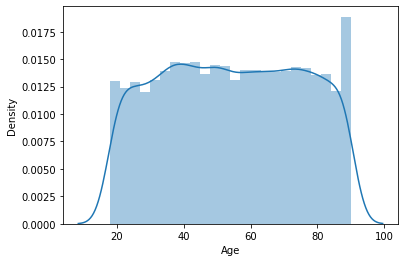

In [41]:
sns.distplot(df['Age'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


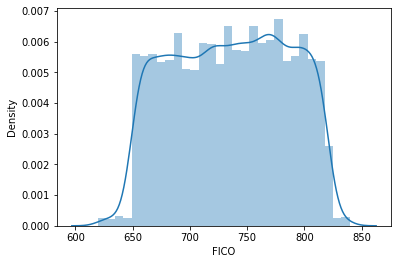

In [42]:
sns.distplot(df['FICO'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


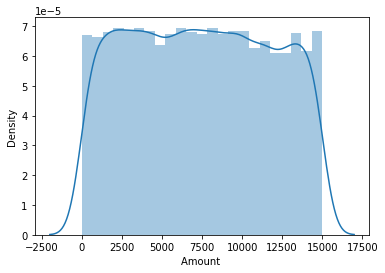

In [44]:
sns.distplot(df['Amount '])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


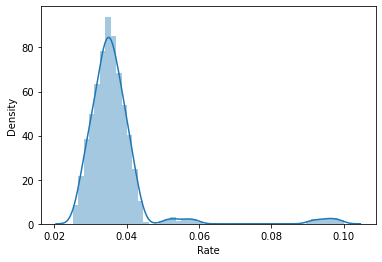

In [45]:
sns.distplot(df['Rate'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


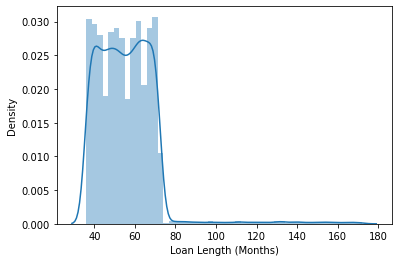

In [46]:
sns.distplot(df['Loan Length (Months)'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


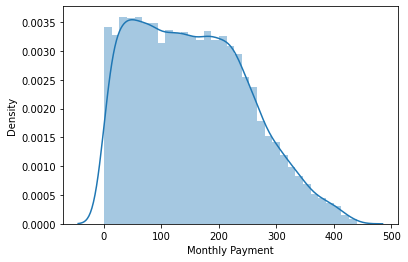

In [47]:
sns.distplot(df['Monthly Payment'])

#Training

In [247]:
hot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11678 entries, 0 to 11677
Data columns (total 41 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                11678 non-null  float64
 1   FICO                               11678 non-null  float64
 2   Amount                             11678 non-null  float64
 3   Rate                               11678 non-null  float64
 4   Loan Length (Months)               11678 non-null  float64
 5   Monthly Payment                    11678 non-null  float64
 6   Gender_Female                      11678 non-null  uint8  
 7   Gender_Male                        11678 non-null  uint8  
 8   Gender_Non-Binary                  11678 non-null  uint8  
 9   Gender_Transexual                  11678 non-null  uint8  
 10  Gender_Undisclosed                 11678 non-null  uint8  
 11  Nationality_American               11678 non-null  uin

In [248]:
hot_df.head()

,Age,FICO,Amount,Rate,Loan Length (Months),Monthly Payment,Gender_Female,Gender_Male,Gender_Non-Binary,Gender_Transexual,...,Employment_Self-Employed,Employment_Teacher,City_Boise,City_Idaho Falls,City_Meridian,City_Moscow,City_Pocatello,City_Spokane,State _ID,State _WA
0,89.0,753.0,7525.523746,0.031827,40.0,198.543417,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,50.0,757.0,7694.543335,0.038852,43.0,191.977148,0,1,0,0,...,1,0,0,0,0,0,1,0,1,0
2,54.0,802.0,421.477281,0.034503,66.0,7.020239,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,24.0,673.0,9360.368977,0.035724,71.0,146.454807,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
4,77.0,809.0,321.883354,0.035149,55.0,6.345033,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [279]:
X = np.array(hot_df)

In [280]:
y = np.array(label_df)
y

array(['Yes', 'Yes', 'No', ..., 'Yes', 'No', 'No'], dtype=object)

In [281]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

In [253]:
clf_tree = DecisionTreeClassifier()

In [254]:
clf_tree.fit(x_train, y_train)

DecisionTreeClassifier()

In [ ]:
list(hot_df.columns)

In [262]:
text_representation = tree.export_text(clf_tree,feature_names=list(hot_df.columns))

In [263]:
print(text_representation)

|--- City_Meridian <= 0.50
|   |--- City_Boise <= 0.50
|   |   |--- City_Idaho Falls <= 0.50
|   |   |   |--- Rate <= 0.05
|   |   |   |   |--- class: Yes
|   |   |   |--- Rate >  0.05
|   |   |   |   |--- Loan Length (Months) <= 90.00
|   |   |   |   |   |--- Loan Length (Months) <= 63.50
|   |   |   |   |   |   |--- Loan Length (Months) <= 62.50
|   |   |   |   |   |   |   |--- Gender_Male <= 0.50
|   |   |   |   |   |   |   |   |--- Amount  <= 3046.12
|   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |--- Amount  >  3046.12
|   |   |   |   |   |   |   |   |   |--- Monthly Payment <= 98.86
|   |   |   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |   |   |--- Monthly Payment >  98.86
|   |   |   |   |   |   |   |   |   |   |--- Amount  <= 7369.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- Amount  >  7369.50
|   |   |   |   |   |   |   |   |   |   |

In [ ]:
fig = plt.figure(figsize=(200,200))
_ = sklearn.tree.plot_tree(tree, 
                   feature_names=hot_df.columns,  
                   class_names=['Yes', 'No'],
                   filled=True)

In [265]:
custom_tree = DecisionTree()

In [ ]:
custom_tree.train(x_train, y_train, x_train.shape[1], 3)

In [284]:
custom_tree.tree["4->['Boise' 'Idaho Falls' 'Meridian' 'Moscow' 'Pocatello' 'Spokane']"][3]

{"10->['month1' 'month2' 'month3' 'month4']": ['Yes',
  'Yes',
  'Yes',
  {"9->['rate1' 'rate2' 'rate3' 'rate4']": ['Yes',
    'Yes',
    'Yes',
    {"8->['amount1' 'amount2' 'amount3' 'amount4']": [{"7->['fioc1' 'fioc2' 'fioc3' 'fioc4']": ['No',
        {"6->['age2q' 'age3q']": ['No', 'Yes']},
        {"6->['age2q' 'age3q' 'age4q']": ['Yes', 'No', 'Yes']},
        'Yes']},
      {"7->['fioc1' 'fioc2' 'fioc3' 'fioc4']": ['No', 'No', 'Yes', 'Yes']},
      'Yes',
      'Yes']}]}]}